## NLP Tutorial - GloVe Vectors Embedding with TF2.0 and Keras 

Watch Full Video: https://youtu.be/YNK-pBXDLzk

Glove Vectors: https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space

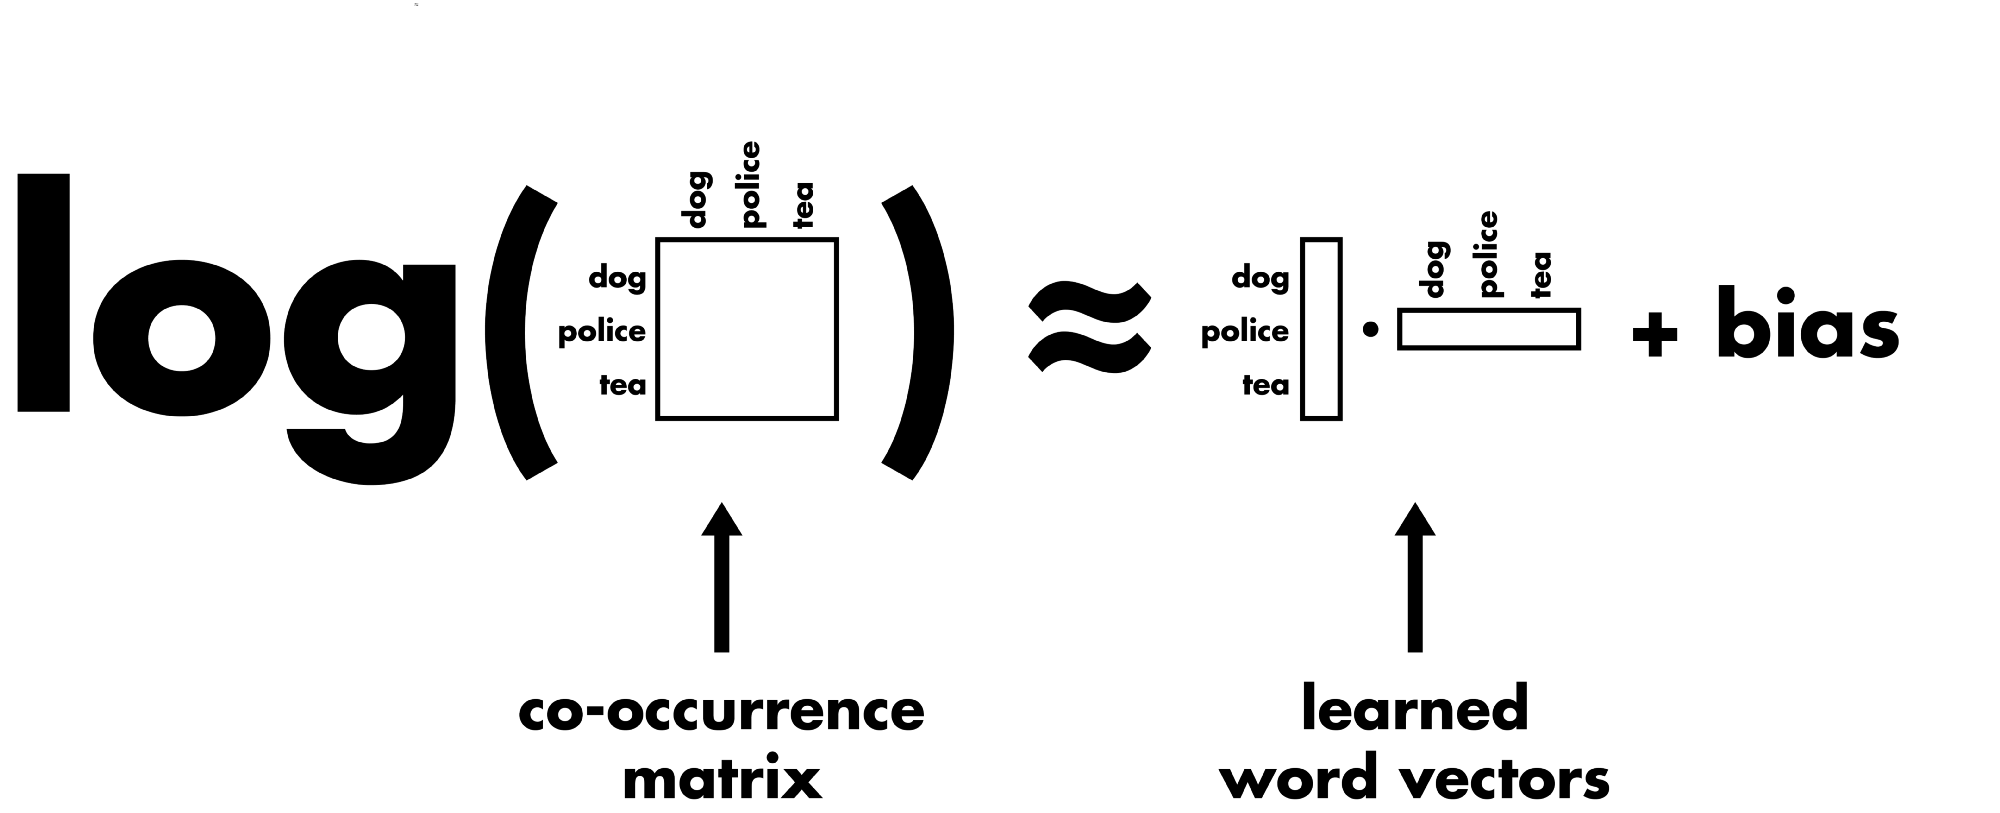

Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download): http://nlp.stanford.edu/data/glove.840B.300d.zip

Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): http://nlp.stanford.edu/data/glove.twitter.27B.zip

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from tensorflow.keras.optimizers import Adam

import numpy as np
from numpy import array
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('twitter4000.csv')
df.head()

,twitts,sentiment
0,is bored and wants to watch a movie any sugge...,0
1,back in miami. waiting to unboard ship,0
2,"@misskpey awwww dnt dis brng bak memoriessss, ...",0
3,ughhh i am so tired blahhhhhhhhh,0
4,@mandagoforth me bad! It's funny though. Zacha...,0


### Preprocessing and Cleaning 

In [4]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and "}

In [5]:
%%time
import re

text = ' '.join(df['twitts'])
text = text.split()
freq_comm = pd.Series(text).value_counts()
rare = freq_comm[freq_comm.values == 1]

def get_clean_text(x):
    if type(x) is str:
        x = x.lower()
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        x = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', x)
        x = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', x)
        x = re.sub('RT', "", x)
        x = re.sub('[^A-Z a-z]+', '', x)
        x = ' '.join([t for t in x.split() if t not in rare])
        return x
    else:
        return x
    
df['twitts'] = df['twitts'].apply(lambda x: get_clean_text(x))        

Wall time: 567 ms


In [6]:
df['twitts']

0       is bored and wants to watch a movie any sugges...
1                                back in miami waiting to
2       misskpey awwww dnt bak memoriessss i i am sad lol
3                                     ughhh i am so tired
4       mandagoforth me bad it is funny though zachary...
                              ...                        
3995                                               i just
3996               templating works it all has to be done
3997                      mommy just brought me starbucks
3998       omarepps watching you on a house rerunlovin it
3999    thanks for trying to make me smile i will make...
Name: twitts, Length: 4000, dtype: object

In [7]:
df['sentiment'].value_counts()

1    2000
0    2000
Name: sentiment, dtype: int64

In [8]:
text = df['twitts'].tolist()
text[:3]

['is bored and wants to watch a movie any suggestions',
 'back in miami waiting to',
 'misskpey awwww dnt bak memoriessss i i am sad lol']

In [9]:
y = df['sentiment']

In [10]:
token = Tokenizer()
token.fit_on_texts(text)

In [11]:
vocab_size  = len(token.word_index) + 1
vocab_size

6793

In [12]:
# print(token.index_word)

In [13]:
# x = ['i to'] #[1, 2]


In [14]:
encoded_text = token.texts_to_sequences(text)

In [15]:
print(encoded_text[:3])

[[5, 279, 9, 315, 2, 182, 4, 217, 202, 2298], [48, 10, 1299, 183, 2], [2299, 1087, 655, 1300, 2300, 1, 1, 13, 114, 46]]


In [16]:
max_length = 120
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [17]:
print(X)

[[   5  279    9 ...    0    0    0]
 [  48   10 1299 ...    0    0    0]
 [2299 1087  655 ...    0    0    0]
 ...
 [ 936   22  925 ...    0    0    0]
 [6791  125    7 ...    0    0    0]
 [  88   12  209 ...    0    0    0]]


In [18]:
X.shape

(4000, 120)

### `GloVe` Vectors 

In [19]:
# you -0.11076 0.30786 -0.5198 0.035138 0.10368 -0.052505 -0.18021 -0.11839 -0.054253 2.498 -0.30241 0.043233 -0.095862 -0.093529 -0.19817 -0.26599 -0.34703 1.4518 -0.49013 0.041637 0.11185 -0.019023 -0.18716 -0.10407 -0.43665 0.073561 0.019546 -0.15012 0.18499 -0.24364 0.20327 0.28916 -0.21694 0.28351 -0.10092 -0.042189 -0.073457 0.27325 -0.12898 -0.059407 -0.073329 0.01249 -0.20459 -0.44558 0.040863 0.24588 -0.26111 -0.086821 0.13628 0.11094 -0.10835 0.0098775 0.17394 0.006475 0.27467 -0.0097433 0.16561 -0.16975 -0.12561 -0.071688 -0.056815 -0.28632 -0.24231 0.27819 0.24112 -0.009142 -0.053634 0.43907 0.39 0.1252 -0.063581 0.058089 0.59187 -0.18385 0.090201 0.13788 0.41051 -0.39034 -0.071701 0.37935 0.031344 -0.003615 -0.25773 -0.048608 0.1952 -0.29912 0.04721 -0.13577 0.67253 -0.083033 -0.1968 0.074079 0.17826 0.20097 -0.036357 0.027783 -0.32144 -0.2962 -0.1326 0.30375 0.05418 0.070012 0.11935 0.04668 0.37338 -0.63809 0.33868 -0.091924 -0.12639 0.068526 0.11981 -0.22509 0.56067 -0.035003 0.36471 -0.26875 -0.0048343 0.064098 -0.2876 -0.023736 0.21348 -0.4122 -0.12958 0.051024 0.42078 -0.086314 -0.10035 -0.26017 0.0096791 0.064299 0.10799 -0.095081 -0.12798 0.054993 0.060576 -0.037241 -0.19778 -0.12237 -0.16846 -0.098457 -1.8562 0.3119 -0.30854 -0.098816 -0.0019955 -0.29415 0.078162 0.18014 -0.027904 -0.049573 0.071973 0.16791 -0.033054 -0.079709 -0.097695 0.26119 0.11585 -0.25638 -0.089019 -0.024823 -0.10813 0.20349 -0.20903 0.18039 0.39647 -0.13119 0.46686 -0.053135 0.014807 0.059119 -0.084577 -0.05861 0.34677 -0.25996 0.052293 0.19285 -0.27362 -0.10858 -0.030143 0.35079 0.20094 0.08739 -0.12402 0.02094 0.041557 -0.026728 -0.025289 -0.34984 -0.078001 0.17182 -0.06293 -0.074751 0.045825 -0.27333 0.23052 0.19061 -0.20641 -0.039203 0.33908 0.52254 -0.10861 -0.30465 -0.053306 -0.26766 -0.0043355 0.23916 0.22283 -0.053289 0.20198 -0.084151 0.10375 -0.35093 -0.19961 0.010933 0.26317 0.34094 -0.068638 0.20576 -0.52757 -0.084815 0.11056 0.021289 0.063286 0.094234 0.20282 -0.15887 -0.010649 0.25771 -0.23234 -0.23733 -0.15439 0.13906 0.086255 0.38443 -0.25632 0.031801 0.080305 -0.40683 -0.51163 0.26979 0.41308 0.057052 0.054701 -0.060832 0.19468 -0.38259 -0.044148 -0.036737 -0.3972 0.55777 0.069855 -0.21519 -0.091095 0.033559 -0.16332 0.42089 0.019067 -0.21884 0.27533 0.23683 0.094193 0.038504 0.2238 -0.11986 0.23199 -0.088445 -0.014716 0.65752 0.59385 0.24571 0.024754 -0.31514 -0.1547 0.00057218 -0.042344 0.081696 0.030109 0.070089 0.08708 -0.079636 -0.0083257 -0.14395 0.038982 -0.095362 0.27599 -0.3907 0.44441 -0.35471 0.2331 -0.0067546 -0.18892 0.27837 -0.38501 -0.11408 0.28191 -0.30946 -0.21878 -0.059105 0.47604 0.05661

In [20]:
df['twitts']

0       is bored and wants to watch a movie any sugges...
1                                back in miami waiting to
2       misskpey awwww dnt bak memoriessss i i am sad lol
3                                     ughhh i am so tired
4       mandagoforth me bad it is funny though zachary...
                              ...                        
3995                                               i just
3996               templating works it all has to be done
3997                      mommy just brought me starbucks
3998       omarepps watching you on a house rerunlovin it
3999    thanks for trying to make me smile i will make...
Name: twitts, Length: 4000, dtype: object

In [21]:
glove_vectors = dict()

In [22]:
%%time
# file = open('glove.twitter.27B.200d.txt', encoding='utf-8')
file = open('glove.twitter.27B.200d.txt', encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1: ])
    glove_vectors[word] = vectors
file.close()

Wall time: 2min 43s


In [23]:
len(glove_vectors)

1193514

In [24]:
keys = glove_vectors.keys()
len(keys)

1193514

In [25]:
glove_vectors.get('aassrfdfa')

In [26]:
glove_vectors.get('you').shape

(200,)

In [27]:
word_vector_matrix = np.zeros((vocab_size, 200))

for word, index in token.word_index.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector
    else:
        print(word)

tommcfly
dougiemcfly
donniewahlberg
kirstiealley
quotthe
peterfacinelli
davidarchie
quoti
youngq
jordanknight
atampt
gtlt
songzyuuup
dannygokey
jackalltimelow
ashleytisdale
jonathanrknight
ughhh
twitterberry
misss
shaaqt
cepic
soooooooooooo
spymaster
notbut
sweetkisses
dcdebbie
earthlifeshop
youquot
ltsobgt
wayyy
workno
heidimontag
mampg
seeee
sohotel
xbllygbsn
damohopo
katlb
anddd
rckergirl
mequot
quotyoure
aplusk
wwwtweeteraddercom
paulgdog
hotwords
deltagoodrem
miamiadc
trvsbrkr
thesupergirl
gailporter
jeffreecuntstar
youngcash
misskpey
memoriessss
mandagoforth
kevinmarquis
peterfacinellis
raisenot
stacig
killahzzzz
sfannah
brianquest
garethemery
kimberleymtkg
daniesass
hungrydomaine
quotmermaid
dinnerquot
shvizut
wellat
shirshor
hummm
jchamanes
scaredddd
andrewhuntre
sonjacassella
darenotspeak
mammaj
jkmrprez
yearquot
haemoglobin
stedic
paulmccourt
greenisland
twilightofdoom
krazyfreak
whyhe
xxbrry
brianrubin
lomara
kankzxd
anthothemantho
antonwheel
hanaames
orlax
bastantep
catshat

guendouglas
eliburford
amazingphoebe
ohhhleann
amberlrhea
jonnybabyy
angeliquebates
onlylies
somereason
errored
kennah
tweetsearch
prettyblacklex
mcrmuffin
janabellexo
carissarogers
atabey
mandahead
jillianvalentin
beautyfulashley
beatersidk
ninjafrog
netamarie
freakshowmikey
fsbigbob
moriqua
vidaecaffe
monkeyspanda
madcatdisease
dyankd
mediatemple
rockpapershot
iblogologist
shontane
steveheath
upwhy
errinmerrrill
rubyam
kellymcfly
mewell
onelet
uncleo
babymaybe
serveri
natalietran
goodbut
ellapsycho
madisonxgeorgie
brownskinbunnies
famnot
teegee
officialmelb
missmel
clickwindrepeat
chiefdork
casuallavish
revisting
cherrywopie
sidestomach
staceyandeen
babiiluv
tomcmfly
visitingchile
sugawright
roninofragnarok
seriouz
akihikio
zwoise
mzkiss
johnchandler
scruffypanther
quotnormalskinnyquot
bfoxb
onepov
quotonce
dreamquot
andreashale
goooodyet
chriskey
townhallforhope
suuuperpach
tonycupcakes
maurillio
charices
officialcharice
refundnow
timdisaster
travdave
skeezoyd
dvartistry
indywoodfil

glidden
collingsa
bhinn
artomatic
mickeymonkeyy
hereya
lizpriore
joshuaradin
futuredirected
vectorlovers
runshouse
djodcouk
riffrecording
bluvox
urasawas
anatomyo
undiess
summmeeerrr
ischoolatdrexel
schenkin
dloesch
mischkas
liamvickery
amandalester
trendall
riskyadinda
donniedoll
lovingpaws
pbcomquot
airsmithing
cashola
againugh
davynathan
sazmows
jesusandmary
uniqueguitarist
lechantdoiseau
tidemark
pavwoahva
paulamcfly
handsheldhigh
nennamusic
chrunchie
ffffrrrriiiiiddddaaaaayyyy
lvatt
paulaabdulfan
jessstroup
ohamps
nikkilorenzo
lthas
quinnspurr
bluelipstx
nissietr
nissieeeehave
elleyevee
creepygnome
shootno
chriscyvas
amylaree
joegigantino
selfneed
ericakelly
therealcabbie
killasluddie
realsed
kevinwweaver
buzzbaker
talktodiane
bringxknives
halfdate
themandymoore
isiswisdom
linacalabria
nightynite
waaaida
pianoooo
katetropa
simchabe
sorrynext
joelmadden
wwwmybigdayplannercom
xxkassyxx
jiamiin
barclub
carlosedp
dailymetv
guysthis
koifishsushi
sscullion
timtech
inklesstales
beehughes

In [28]:
word_vector_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### model building 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

In [30]:
vec_size = 200

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length, weights = [word_vector_matrix], trainable = False))

model.add(Conv1D(64, 8, activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 30, validation_data = (X_test, y_test))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3200 samples, validate on 800 samples
Epoch 1/30
3200/3200 [==============================] - 10s 3ms/sample - loss: 0.7431 - acc: 0.5000 - val_loss: 0.6940 - val_acc: 0.4975
Epoch 2/30
3200/3200 [==============================] - 3s 933us/sample - loss: 0.7102 - acc: 0.5231 - val_loss: 0.6836 - val_acc: 0.5625
Epoch 3/30
3200/3200 [==============================] - 3s 826us/sample - loss: 0.6977 - acc: 0.5384 - val_loss: 0.6781 - val_acc: 0.5975
Epoch 4/30
3200/3200 [==============================] - 2s 743us/sample - loss: 0.6871 - acc: 0.5641 - val_loss: 0.6727 - val_acc: 0.6137
Epoch 5/30
3200/3200 [==============================] - 3s 933us/sample 

In [31]:
def get_encode(x):
    x = get_clean_text(x)
    x = token.texts_to_sequences(x)
    x = pad_sequences(x, maxlen=max_length, padding='post')
    return x

In [35]:
get_encode(["i hi how are you isn't"])

array([[  1, 318,  77,  37,   7,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]])

In [36]:
model.predict_classes(get_encode(['thank you for watching']))

array([[1]])